In [1]:
from tensorflow import __version__
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input, Reshape, MaxPooling1D, Conv1D, Dense, Flatten, Dropout
from tensorflow.python.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os

print("Tensorflow version: {}".format(__version__))

base_dir = "/Users/jamesgolding/git/python/machinelearning/alert"

print(os.listdir(base_dir))

Tensorflow version: 1.11.0
['.DS_Store', 'AlertLogisticRegressionKeras.ipynb', '.ipynb_checkpoints', 'data']


Training Set:
Number Positive: 349785
Number Negative: 254544


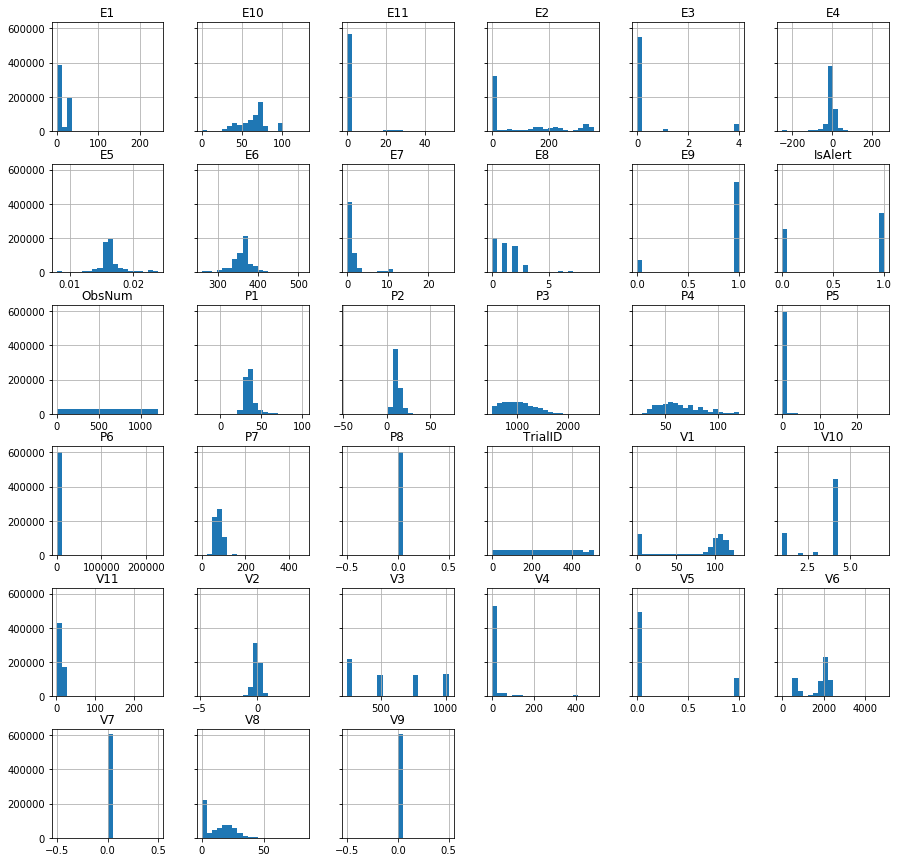

In [2]:
# load training data and plot
df_train = pd.read_csv(base_dir + "/data/fordTrain.csv")
df_submt = pd.read_csv(base_dir + "/data/fordTest.csv")
df_train.hist(figsize=(15, 15), bins=20, sharey=True);
#
num_train_pos = sum(df_train["IsAlert"].values);
num_train_neg = len(df_train["IsAlert"].values) - num_train_pos;
print("Training Set:")
print("Number Positive: {}".format(num_train_pos))
print("Number Negative: {}".format(num_train_neg))

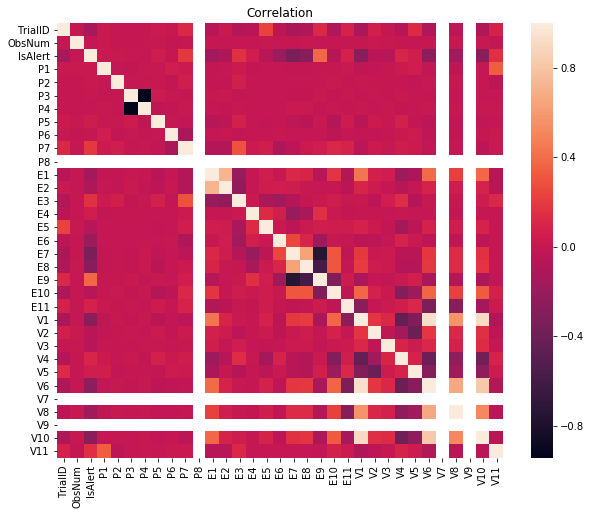

In [3]:
plt.figure(figsize=(10, 8))
seaborn.heatmap(df_train.corr())
plt.title("Correlation");

In [4]:
# list the columns we don't want 
col_names = list(df_train)
cols_rem = ["P8", "V7", "V9"]
set_diff = list(set(col_names) - set(cols_rem))
# remove them
df_train = df_train[set_diff];
df_submt = df_submt[set_diff];

In [5]:
# extract independent and dependent variables
col_names_x = list(set(list(df_train)) - set(["IsAlert", "TrainID", "ObsNum"]))
def convert2xy(df):
    col_names = list(df)
    y = df["IsAlert"].values;
    x = df[col_names_x].values;
    ids = df["TrialID"].values;
    return x, y
# get training and submission sets
X_train, y_train = convert2xy(df_train)
X_submt, y_submt = convert2xy(df_submt)
# scale x
scX = StandardScaler()
X_train = scX.fit_transform(X_train)
X_submt = scX.transform(X_submt)
# split training set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)
# get number of independent variables
sz_input = len(col_names_x)

In [6]:
# define model
model = Sequential()
model.add(InputLayer(input_shape=(sz_input,)))
# two fully connected layers
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='normal'))
model.add(Dense(1, activation='sigmoid'))
# simple optimizer
optimizer = Adam(lr=1e-4)
# set queuing config
num_batch = 150
num_epochs = 20
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1856      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,081
Trainable params: 6,081
Non-trainable params: 0
_________________________________________________________________


[1.37416321 1.37416321 1.37416321 ... 1.37416321 1.         1.        ]
Epoch 1/20
483463/483463 [==============================] - 6s 12us/step - loss: 0.4688 - acc: 0.7766
Epoch 2/20
483463/483463 [==============================] - 5s 10us/step - loss: 0.4346 - acc: 0.8017
Epoch 3/20
483463/483463 [==============================] - 5s 11us/step - loss: 0.4287 - acc: 0.8059: 0s - loss: 0.429
Epoch 4/20
483463/483463 [==============================] - 5s 10us/step - loss: 0.4262 - acc: 0.8073
Epoch 5/20
483463/483463 [==============================] - 5s 10us/step - loss: 0.4239 - acc: 0.8089
Epoch 6/20
483463/483463 [==============================] - 5s 11us/step - loss: 0.4235 - acc: 0.8089
Epoch 7/20
483463/483463 [==============================] - 5s 11us/step - loss: 0.4226 - acc: 0.8097
Epoch 8/20
483463/483463 [==============================] - 5s 10us/step - loss: 0.4222 - acc: 0.8103
Epoch 9/20
483463/483463 [==============================] - 5s 11us/step - loss: 0.4214 - acc:

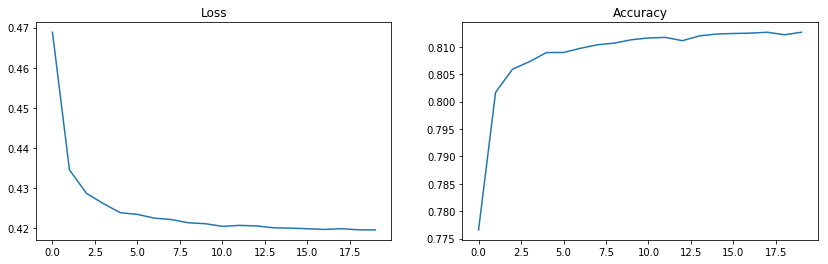

In [7]:
# set class weights
sample_weight = 1 * (y_train == 1) + num_train_pos/num_train_neg * (y_train == 0)
print(sample_weight)
# compile the model, define the loss function and metrics
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]);
# fit to the training data
history = model.fit(x=X_train, y=y_train, sample_weight=sample_weight, epochs=num_epochs, batch_size=num_batch);
# plot the history
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(4)
axes[0].plot(history.history["loss"]);
axes[0].set_title("Loss");
axes[1].plot(history.history["acc"]);
axes[1].set_title("Accuracy");

In [8]:
print("Test Set Accuracy\n")
# evaluate the model for the test set
result = model.evaluate(x=X_test, y=y_test)
y_pred = model.predict(x=X_test)
y_pred = np.round(y_pred).reshape(-1)
# print the accuracy for every result
for name, value in zip(model.metrics_names, result):
    print(name, value)

Test Set Accuracy

120866/120866 [==============================] - 2s 14us/step
loss 0.40950985792414957
acc 0.813802061787434


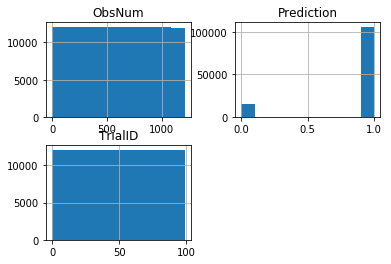

In [9]:
# put together submission results
y_submt_pred = model.predict(x=X_submt)
y_submt_pred = np.round(y_submt_pred).flatten()
# format result
arr = np.vstack((df_submt["TrialID"].values.T, df_submt["ObsNum"].values.T, y_submt_pred.T)).T
index = np.arange(0, arr.shape[0])
columns = ["TrialID", "ObsNum", "Prediction"]
df_result = pd.DataFrame(arr, index=index, columns=columns)
df_result.hist();